In [87]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [88]:
base_dir = "/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification"

In [89]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [90]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [91]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

In [92]:
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [93]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 9246 images belonging to 2 classes.


In [94]:
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 829 images belonging to 2 classes.


In [95]:
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 506 images belonging to 2 classes.


In [96]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(*IMG_SIZE, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [97]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [98]:
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

In [99]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 110s 368ms/step - accuracy: 0.6565 - loss: 0.6197 - val_accuracy: 0.8299 - val_loss: 0.3888
Epoch 2/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 106s 368ms/step - accuracy: 0.8569 - loss: 0.3444 - val_accuracy: 0.8926 - val_loss: 0.3240
Epoch 3/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 108s 373ms/step - accuracy: 0.9100 - loss: 0.2328 - val_accuracy: 0.9228 - val_loss: 0.2395
Epoch 4/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 108s 375ms/step - accuracy: 0.9415 - loss: 0.1523 - val_accuracy: 0.9349 - val_loss: 0.2112
Epoch 5/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 108s 375ms/step - accuracy: 0.9607 - loss: 0.1213 - val_accuracy: 0.9361 - val_loss: 0.1842
Epoch 6/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 106s 368ms/step - accuracy: 0.9655 - loss: 0.1007 - val_accuracy: 0.9264 - val_loss: 0.1898
Epoch 7/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 106s 367ms/step - accuracy: 0.9668 - loss: 0.0910 - val_accuracy: 0.9445 - val_loss: 0.1808
Epoch 8/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 107s 370ms/step - accuracy: 0.9736 -

In [100]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 488ms/step - accuracy: 0.9860 - loss: 0.0263
Test Accuracy: 0.98


In [101]:
model.save("fracture.h5")

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 228ms/step


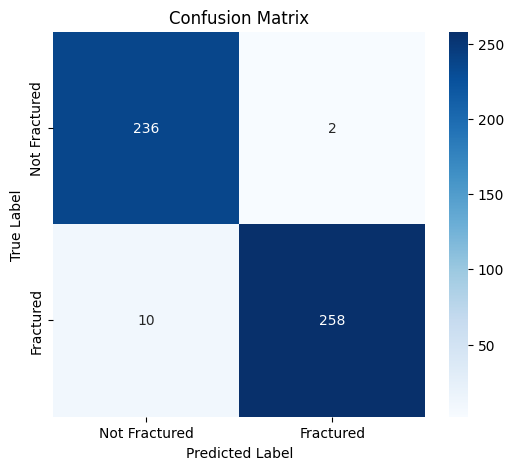

               precision    recall  f1-score   support

Not Fractured       0.96      0.99      0.98       238
    Fractured       0.99      0.96      0.98       268

     accuracy                           0.98       506
    macro avg       0.98      0.98      0.98       506
 weighted avg       0.98      0.98      0.98       506



In [102]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

Y_pred = model.predict(test_generator)
Y_pred_classes = (Y_pred > 0.5).astype("int32")
Y_true = test_generator.classes

cm = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fractured', 'Fractured'], yticklabels=['Not Fractured', 'Fractured'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
print(classification_report(Y_true, Y_pred_classes, target_names=['Not Fractured', 'Fractured']))


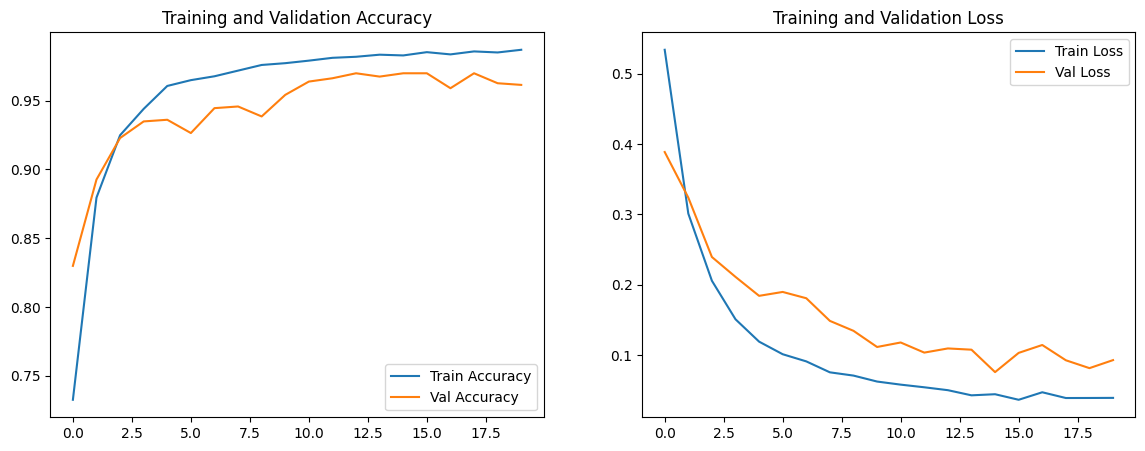

In [103]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

plot_training_history(history)